# Kepler Framework Examples

In [1]:
from kepler.pandas.menu       import ElectronSequence as Chain
from kepler.pandas.readers    import load, load_in_loop
from kepler.pandas.decorators import create_ringer_v8_decorators, create_ringer_v9_decorators, RingerDecorator
from kepler.pandas.decorators import create_ringer_v8_new_decorators, create_ringer_v8_half_fast_decorators, create_ringer_v8_34_decorators, create_ringer_v8_half_decorators, create_ringer_v8_14_decorators, create_ringer_v12_decorators

import kepler
import tqdm
import rootplotlib as rpl
import mplhep as hep
import root_numpy
import ROOT
ROOT.gStyle.SetOptStat(0);
import array

import numpy as np
import pandas as pd
import collections
import os
from pprint import pprint
from copy import deepcopy
import gc


import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import mplhep as hep

import warnings
warnings.filterwarnings('ignore')
plt.style.use(hep.style.ROOT)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


##### kWhite  = 0,   kBlack  = 1,   kGray    = 920,  kRed    = 632,  kGreen  = 416,
##### kBlue   = 600, kYellow = 400, kMagenta = 616,  kCyan   = 432,  kOrange = 800,
##### kSpring = 820, kTeal   = 840, kAzure   =  860, kViolet = 880,  kPink   = 900

https://root.cern.ch/doc/master/classTColor.html

In [2]:
def hist1d( name, values, bins, density=False ):
    counts, dummy = np.histogram(values, bins=bins, density=density )
    hist = ROOT.TH1F( name, '', len(bins)-1, array.array('d',bins))
    root_numpy.array2hist(counts, hist)
    return hist

colors  = [ROOT.kBlack, ROOT.kBlue+1, ROOT.kGreen+1, ROOT.kRed+1] # Primarias
#colors  = [ROOT.kBlue-4, ROOT.kBlack, ROOT.kGreen-4, ROOT.kGray] # cores do Mica
#markers = [22, 26, 23, 32]
markers = [33, 22, 23, 30]

def add_legend(x, y, legends):
    rpl.add_legend( legends, x, y, x+0.98, y+0.20, textsize=12, option='p' )

In [3]:
chain_list = {
    'e24_lhtight_nod0_{RINGER}_ivarloose':'L1_EM22VHI',
    'e26_lhtight_nod0_{RINGER}_ivarloose':'L1_EM22VHI',
    'e60_lhmedium_nod0_{RINGER}_L1EM24VHI':'L1_EM24VHI',
    'e140_lhloose_nod0_{RINGER}':'L1_EM24VHI',
}

steps = [
    'L2Calo',
    'L2',
    'EFCalo',
    'HLT',
]


default_algorithms = {#column_name:label
                      'noringer':'NoRinger',
                      'ringer_v8_new':'Ringer V8',
                      'ringer_v8_half':'Ringer V8.1/2',
                      }
selected_ringer = {
                    #'ringer_v8_34':'Ringer V8.3/4',
                    'ringer_v8_14':'Ringer V8.1/4',
                    #'ringer_v12':'Ringer V12(lor)',
                  }


ringer_list = list(default_algorithms.keys()) + list(selected_ringer.keys())

if len(ringer_list) != 4:
    raise ValueError
print(ringer_list)

label_list = list(default_algorithms.values()) + list(selected_ringer.values())
print(label_list)

['noringer', 'ringer_v8_new', 'ringer_v8_half', 'ringer_v8_14']
['NoRinger', 'Ringer V8', 'Ringer V8.1/2', 'Ringer V8.1/4']


# Running for Zee samples

In [4]:
## codigo original
# dpath = '/home/jodafons/public/cern_data/new_files/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins'
# dpath+= '/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins_et{ET}_eta{ETA}.npz'
# paths = []
# for et in range(5):
#     for eta in range(5):
#         paths.append( dpath.format(ET=et,ETA=eta) )

real_run = False

## Load Data

In [5]:
# codigo modificado
dpath = '/home/pedro.lima/data/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins'
dpath+= '/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins_et{ET}_eta{ETA}.npz'
#                                               \
#                                           very loose
paths = []

dev = True
#    False carrega todas as regioes

if dev:
    range_et = [1]   #leblon = 4
    range_eta = [0]  #leblon = 0
else:
    range_et = range(5)
    range_eta = range(5)

for et in range_et:
    for eta in range_eta:
        paths.append( dpath.format(ET=et,ETA=eta) )
# look here: https://github.com/ringer-softwares/kolmov/blob/master/kolmov/utils/constants.py

In [6]:
drop_columns = [
                    'RunNumber', 
                    #'avgmu',
                    #'trig_L2_cl_et',
                    #'trig_L2_cl_eta',
                    #'trig_L2_cl_phi',
                    #'trig_L2_cl_reta',
                    #'trig_L2_cl_ehad1', 
                    #'trig_L2_cl_eratio',
                    #'trig_L2_cl_f1', 
                    #'trig_L2_cl_f3', 
                    #'trig_L2_cl_weta2', 
                    #'trig_L2_cl_wstot', 
                    'trig_L2_cl_e2tsts1',
                    'trig_L2_el_hastrack',
                    #'trig_L2_el_pt',
                    'trig_L2_el_eta',
                    'trig_L2_el_phi',
                    'trig_L2_el_caloEta',
                    'trig_L2_el_trkClusDeta',
                    'trig_L2_el_trkClusDphi',
                    'trig_L2_el_etOverPt',
                    'trig_EF_cl_hascluster',
                    #'trig_EF_cl_et',
                    'trig_EF_cl_eta',
                    'trig_EF_cl_etaBE2',
                    'trig_EF_cl_phi',     
                    'trig_EF_el_hascand',
                    #'trig_EF_el_et',
                    'trig_EF_el_eta',
                    'trig_EF_el_etaBE2',
                    'trig_EF_el_phi',
                    'trig_EF_el_rhad1',
                    'trig_EF_el_rhad',
                    'trig_EF_el_f3',
                    'trig_EF_el_weta2',
                    'trig_EF_el_rphi',
                    'trig_EF_el_reta',
                    'trig_EF_el_wtots1',
                    'trig_EF_el_eratio',
                    'trig_EF_el_f1',
                    'trig_EF_el_hastrack',
                    'trig_EF_el_deltaEta1',
                    'trig_EF_el_deltaPhi2',
                    'trig_EF_el_deltaPhi2Rescaled',
                    #'trig_EF_el_lhtight',
                    #'trig_EF_el_lhmedium',
                    #'trig_EF_el_lhloose',
                    #'trig_EF_el_lhvloose', 
                    # Offline variables
                    #'el_et',
                    #'el_eta',
                    'el_etaBE2',
                    #'el_phi',
                    # offline shower shapers
                    #'el_rhad1',
                    #'el_rhad',
                    #'el_f3',
                    #'el_weta2',
                    #'el_rphi',
                    #'el_reta',
                    #'el_wtots1',
                    #'el_eratio',
                    #'el_f1',
                    # offline track
                    #'el_hastrack',
                    'el_numberOfBLayerHits',
                    'el_numberOfPixelHits',
                    'el_numberOfTRTHits',
                    #'el_d0',
                    #'el_d0significance',
                    #'el_eProbabilityHT',
                    'el_trans_TRT_PID',
                    #'el_deltaEta1',
                    'el_deltaPhi2',
                    #'el_deltaPhi2Rescaled',
                    #'el_deltaPOverP',
                    #'el_lhtight',
                    #'el_lhmedium',
                    #'el_lhloose',
                    #'el_lhvloose',
                    'el_TaP_Mass',
                    #'el_TaP_deltaR',
                ] 

# variaveis dos aneis...para plotar o perfil médio, preciso deixar
#drop_columns.extend( ['trig_L2_cl_ring_%d'%i for i in range(100)] )

In [7]:
os.environ['RINGER_TUNING_PATH']='/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings'

decorators = create_ringer_v8_new_decorators()
decorators += create_ringer_v8_half_fast_decorators()
#decorators += create_ringer_v8_34_decorators()
decorators += create_ringer_v8_14_decorators()
#decorators += create_ringer_v12_decorators()

2022-12-07 12:24:14,674 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.conf
2022-12-07 12:24:20,692 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.conf
2022-12-07 12:24:21,297 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.conf
2022-12-07 12:24:21,915 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.conf
2022-12-07 12:24:22,326 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20210907_v8-1/ElectronRin

2022-12-07 12:24:14.847797: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-07 12:24:15.419274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 12:24:15.419473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.575GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-07 12:24:15.419494: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-07 12:24:15.660212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-07 12:24:15.753653: I tensorflow/stream_executor

## Setup Chains

ivarloose - é o isolamento loose. Olhar https://twiki.cern.ch/twiki/bin/view/Atlas/TriggerNamingRun2    https://twiki.cern.ch/twiki/bin/view/Atlas/TriggerMenuConvention

ivarloose (Run2 que deve ser mantido para o Run3)- HLT isolation: ptvarcone20/ET<0.1

O pid_name da cadeia está marcado no `lh*` , onde * é o pid_name (ponto de operação da cadeia)

In [10]:
chains = list()

for chain in chain_list:
    for alg in ringer_list:
        if alg == 'noringer':
            chains.append(Chain(("HLT_"+chain).format(RINGER=alg), L1Seed = chain_list[chain]))
        else:
            chains.append(Chain(("HLT_"+chain).format(RINGER=alg), L1Seed = chain_list[chain], l2calo_column = alg+'_'+(chain.split('_')[1][2:])))

OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'trig_L2_cl_lhtight_et22toInf')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_new_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_half_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_14_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
Ordered

## Read all bins

In [11]:
table = load_in_loop( paths, drop_columns=drop_columns, decorators=decorators, chains=chains )

Reading files...: 100%|██████████| 1/1 [00:51<00:00, 51.36s/it]


In [ ]:
if True:
    print(table.columns.to_list())

['avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta', 'trig_L2_cl_phi', 'trig_L2_cl_reta', 'trig_L2_cl_ehad1', 'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_f3', 'trig_L2_cl_weta2', 'trig_L2_cl_wstot', 'trig_L2_cl_ring_0', 'trig_L2_cl_ring_1', 'trig_L2_cl_ring_2', 'trig_L2_cl_ring_3', 'trig_L2_cl_ring_4', 'trig_L2_cl_ring_5', 'trig_L2_cl_ring_6', 'trig_L2_cl_ring_7', 'trig_L2_cl_ring_8', 'trig_L2_cl_ring_9', 'trig_L2_cl_ring_10', 'trig_L2_cl_ring_11', 'trig_L2_cl_ring_12', 'trig_L2_cl_ring_13', 'trig_L2_cl_ring_14', 'trig_L2_cl_ring_15', 'trig_L2_cl_ring_16', 'trig_L2_cl_ring_17', 'trig_L2_cl_ring_18', 'trig_L2_cl_ring_19', 'trig_L2_cl_ring_20', 'trig_L2_cl_ring_21', 'trig_L2_cl_ring_22', 'trig_L2_cl_ring_23', 'trig_L2_cl_ring_24', 'trig_L2_cl_ring_25', 'trig_L2_cl_ring_26', 'trig_L2_cl_ring_27', 'trig_L2_cl_ring_28', 'trig_L2_cl_ring_29', 'trig_L2_cl_ring_30', 'trig_L2_cl_ring_31', 'trig_L2_cl_ring_32', 'trig_L2_cl_ring_33', 'trig_L2_cl_ring_34', 'trig_L2_cl_ring_35', 'trig_L2_cl_ring_36',

In [ ]:
table.head()

,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,trig_L2_cl_weta2,...,L1Calo_e140_lhloose_nod0_ringer_v8_half,L2Calo_e140_lhloose_nod0_ringer_v8_half,L2_e140_lhloose_nod0_ringer_v8_half,EFCalo_e140_lhloose_nod0_ringer_v8_half,HLT_e140_lhloose_nod0_ringer_v8_half,L1Calo_e140_lhloose_nod0_ringer_v8_14,L2Calo_e140_lhloose_nod0_ringer_v8_14,L2_e140_lhloose_nod0_ringer_v8_14,EFCalo_e140_lhloose_nod0_ringer_v8_14,HLT_e140_lhloose_nod0_ringer_v8_14
0,44.700001,26398.796875,0.250705,-2.414006,0.954793,-74.0,0.763824,0.392083,0.004345,0.010794,...,True,False,False,False,False,True,False,False,False,False
1,44.700001,23008.484375,-0.403327,-0.753800,0.978263,95.0,0.980205,0.413226,0.006821,0.009745,...,False,False,False,False,False,False,False,False,False,False
2,44.700001,28512.113281,-0.515492,-2.855384,0.973710,-2.5,0.972953,0.337749,0.009368,0.009951,...,True,False,False,False,False,True,False,False,False,False
3,44.700001,27343.960938,0.072971,3.106292,0.943693,-31.0,0.968486,0.449681,0.004461,0.011055,...,True,False,False,False,False,True,False,False,False,False
4,44.630001,27754.544922,0.777727,-0.467789,0.886613,-87.0,0.984637,0.455884,0.002795,0.010483,...,False,False,False,False,False,False,False,False,False,False


## Efficiency plots

### Efficiency with respect to $E_T$

In [ ]:
def make_et_plot(dataframe, chain, fake=False):
    var = 'trig_L2_cl_et'
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [4,7,10,15,20,25,30,35,40,45,50,60,80,150,300] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    #m_bins = np.arange(3, 16, step=.5).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    offline = chain.split('_')[2]
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                *GeV
    else:
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('et_num', passed[var]/GeV, m_bins )
    #                                       /GeV
    h_den = hist1d('et_den', total[var]/GeV, m_bins )
    #                                      /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

[[<ROOT.TH1F object ("et_num_ratio") at 0x27649a90> 0.49028507426864715]
 [<ROOT.TH1F object ("et_num_ratio") at 0x2e3dd350> 0.4937503095320637]
 [<ROOT.TH1F object ("et_num_ratio") at 0x275fc720> 0.493592591040523]
 [<ROOT.TH1F object ("et_num_ratio") at 0x27660c70> 0.49245884652162153]]
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e24_lhtight_root
[[<ROOT.TH1F object ("et_num_ratio") at 0x2680a220> 0.5064883542460803]
 [<ROOT.TH1F object ("et_num_ratio") at 0x278848d0> 0.5100004968897071]
 [<ROOT.TH1F object ("et_num_ratio") at 0x276b1ec0> 0.5098372331288198]
 [<ROOT.TH1F object ("et_num_ratio") at 0x267ddd70> 0.5086652043912431]]
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e26_lhtight_root
[[<ROOT.TH1F object ("et_num_ratio") at 0x275fc720> 0.0]
 [<ROOT.TH1F object ("et_num_ratio") at 0x27660c70> 0.0]
 [<ROOT.TH1F object ("et_num_ratio") at 0x879d3e0> 0.0]
 [<ROOT

ZeroDivisionError: division by zero

Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et/eff_et_L2Calo_e60_lhmedium_root.pdf has been crea

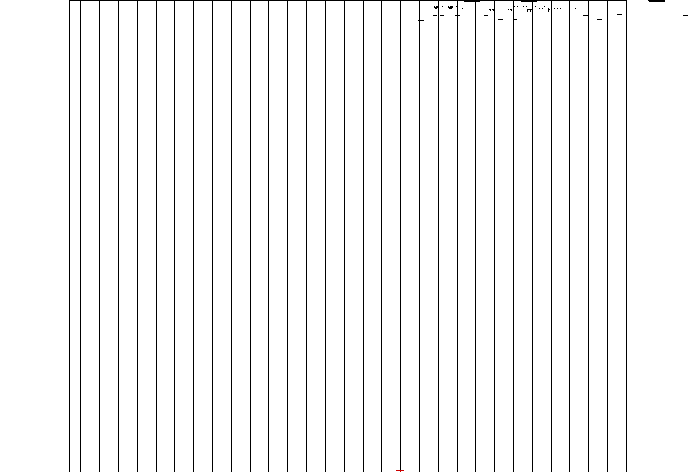

In [30]:
for step in steps:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et'
    
    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_et_plot(table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'E_{T} [GeV]', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_et_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_et_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_et_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e140_lhloose_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2_e140_lhloose_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et/fr_et_L2Calo_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kep

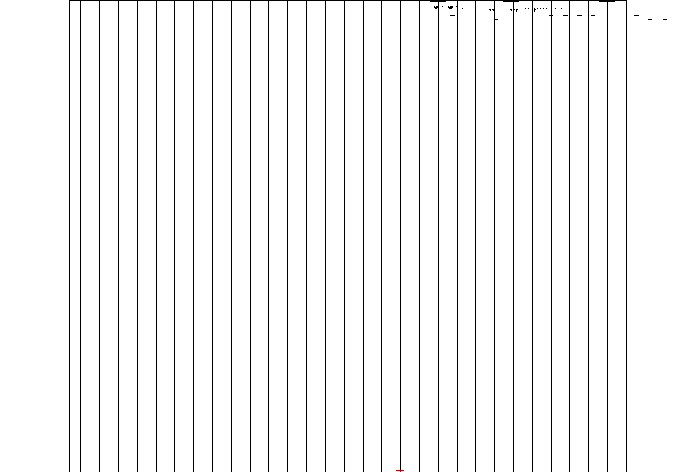

In [33]:
for step in steps:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/et'

    for chain in chain_list:
        trigger = step+'_'+chain

        m_info = np.array([make_et_plot(table, trigger.format(RINGER=alg), fake=True) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'E_{T} [GeV]', colors, markers, ylabel='Fake Rate')
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/fr_et_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_et_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_et_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

### Efficiency with respect to $\eta$

In [14]:
def make_eta_plot(dataframe, chain, fake=False):
    var = 'trig_L2_cl_eta'
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [-2.47,-2.37,-2.01,-1.81,-1.52,-1.37,-1.15,-0.80,-0.60,-0.10,0.00,
              0.10, 0.60, 0.80, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37, 2.47]
    
    et_cut  = int(chain.split('_')[1][1:])
    offline = chain.split('_')[2]
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                *GeV
    else:
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('eta_num', passed[var], m_bins )
    h_den = hist1d('eta_den', total[var], m_bins )
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta/eff_eta_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler

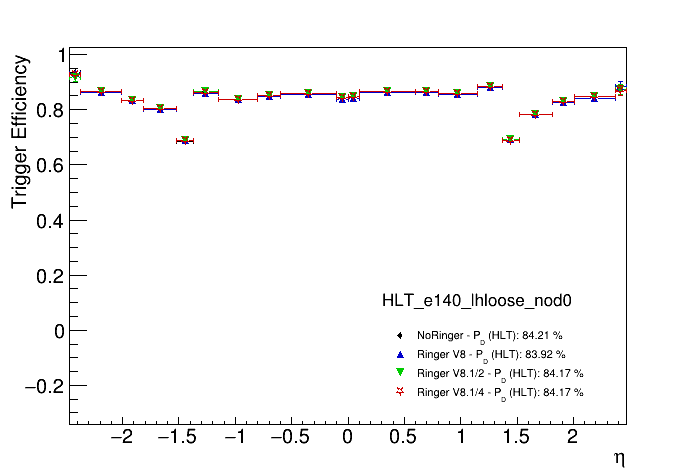

In [15]:
for step in steps:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/eta'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_eta_plot(table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '#eta', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1)
        fig.show()
        print('Saving '+ plot_path+'/eff_eta_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_eta_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_eta_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta/fr_eta_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_

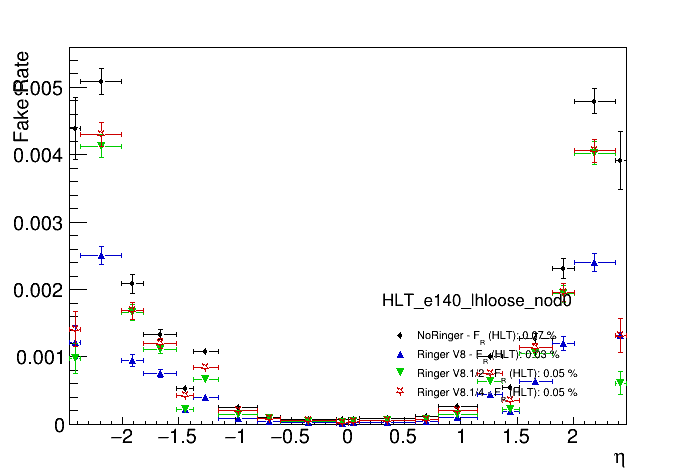

In [16]:
for step in steps:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/eta'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_eta_plot(table, trigger.format(RINGER=alg), fake=True) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '#eta', colors, markers, ylabel='Fake Rate')
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1)
        fig.show()
        print('Saving '+ plot_path+'/fr_eta_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_eta_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_eta_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

### Efficiency with respect to $pT$

In [17]:
def make_pt_plot(dataframe, chain, fake=False):
    var = 'trig_L2_el_pt'
    from Gaugi.constants import GeV, MeV
    # plot in eta need sum 1 in chain threshold 

    #m_bins = [4,7,10,15,20,25,30,35,40,45,50,60,80,150,300] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    m_bins = np.arange(0, 2000*10**3//2, step=50*10**3).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('pt_num', passed[var]/MeV, m_bins )
    #                                               /GeV
    h_den = hist1d('pt_den', total[var]/MeV, m_bins )
    #                                              /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_pt_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_

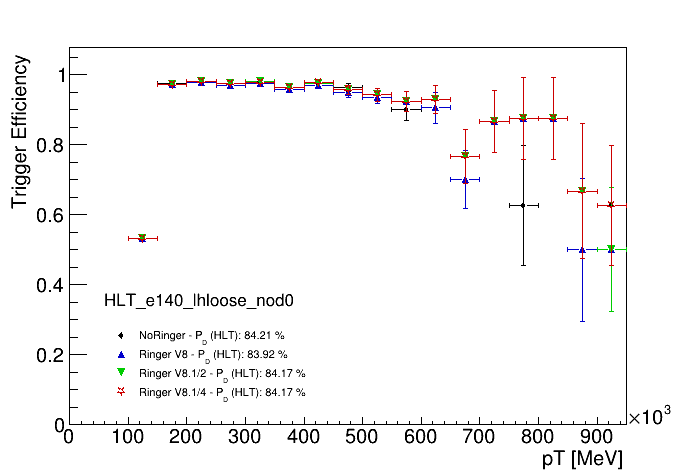

In [18]:
for step in steps:
#step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_pt_plot(table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'pT [MeV]', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.15,0.15, labels)
        rpl.add_text( 0.15, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=0, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_pt_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_pt_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_pt_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt/fr_pt_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs

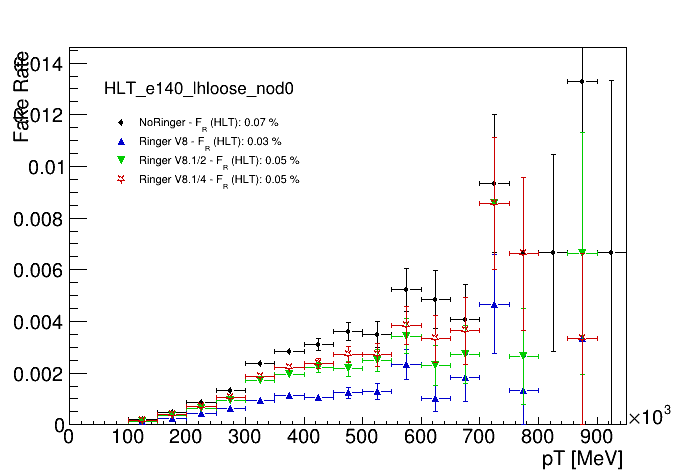

In [19]:
for step in steps:
    #step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/pt'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_pt_plot(table, trigger.format(RINGER=alg), fake=True) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'pT [MeV]', colors, markers, ylabel = 'Fake Rate')
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.15,0.6, labels)
        rpl.add_text( 0.15, 0.8, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=0, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/fr_pt_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_pt_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/fr_pt_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

### Efficiency with respect to $< \mu >$

In [20]:
def make_mu_plot(dataframe, chain, fake=False):
    var = 'avgmu'
    from Gaugi.constants import GeV, MeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [10, 20, 30, 40, 50, 60, 70] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    #m_bins = np.arange(0, 2000*10**3, step=50*10**3).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('mu_num', passed[var]/MeV, m_bins )
    #                                               /GeV
    h_den = hist1d('mu_den', total[var]/MeV, m_bins )
    #                                              /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu/eff_mu_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_

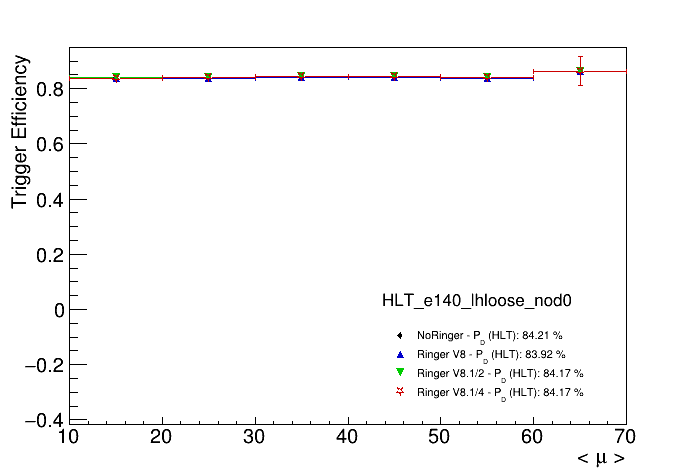

In [21]:
for step in steps:
#step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_mu_plot(table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_mu_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_mu_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_mu_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e140_lhloose_root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu/eff_mu_HLT_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs

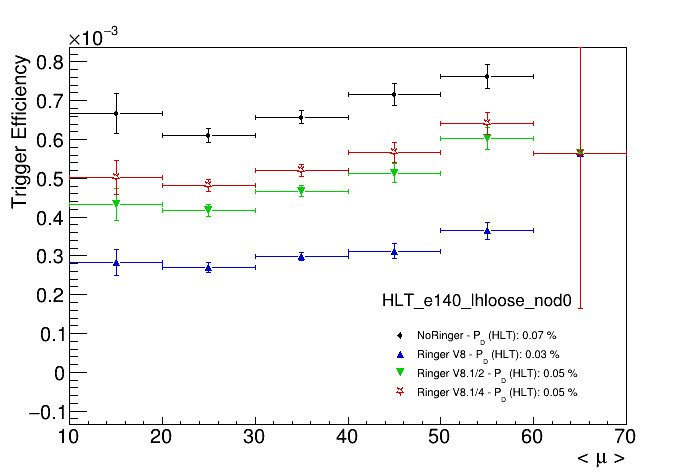

In [22]:
for step in steps:
#step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/frs/mu'

    for chain in chain_list:

        trigger = step+'_'+chain
        
        m_info = np.array([make_mu_plot(table, trigger.format(RINGER=alg), fake=True) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_mu_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_mu_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_mu_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

# Running for Boosted

##### kWhite  = 0,   kBlack  = 1,   kGray    = 920,  kRed    = 632,  kGreen  = 416,
##### kBlue   = 600, kYellow = 400, kMagenta = 616,  kCyan   = 432,  kOrange = 800,
##### kSpring = 820, kTeal   = 840, kAzure   =  860, kViolet = 880,  kPink   = 900

https://root.cern.ch/doc/master/classTColor.html

In [2]:
def hist1d( name, values, bins, density=False ):
    counts, dummy = np.histogram(values, bins=bins, density=density )
    hist = ROOT.TH1F( name, '', len(bins)-1, array.array('d',bins))
    root_numpy.array2hist(counts, hist)
    return hist

colors  = [ROOT.kBlack, ROOT.kBlue+1, ROOT.kGreen+1, ROOT.kRed+1] # Primarias
#colors  = [ROOT.kBlue-4, ROOT.kBlack, ROOT.kGreen-4, ROOT.kGray] # cores do Mica
#markers = [22, 26, 23, 32]
markers = [33, 22, 23, 30]

def add_legend(x, y, legends):
    rpl.add_legend( legends, x, y, x+0.98, y+0.20, textsize=12, option='p' )

In [3]:
chain_list = {
    'e24_lhtight_nod0_{RINGER}_ivarloose':'L1_EM22VHI',
    'e26_lhtight_nod0_{RINGER}_ivarloose':'L1_EM22VHI',
    'e60_lhmedium_nod0_{RINGER}_L1EM24VHI':'L1_EM24VHI',
    'e140_lhloose_nod0_{RINGER}':'L1_EM24VHI',
}

steps = [
    'L2Calo',
    'L2',
    'EFCalo',
    'HLT',
]


default_algorithms = {#column_name:label
                      'noringer':'NoRinger',
                      'ringer_v8_new':'Ringer V8',
                      'ringer_v8_half':'Ringer V8.1/2',
                      }
selected_ringer = {
                    #'ringer_v8_34':'Ringer V8.3/4',
                    'ringer_v8_14':'Ringer V8.1/4',
                    #'ringer_v12':'Ringer V12(lor)',
                  }


ringer_list = list(default_algorithms.keys()) + list(selected_ringer.keys())

if len(ringer_list) != 4:
    raise ValueError
print(ringer_list)

label_list = list(default_algorithms.values()) + list(selected_ringer.values())
print(label_list)

['noringer', 'ringer_v8_new', 'ringer_v8_half', 'ringer_v8_14']
['NoRinger', 'Ringer V8', 'Ringer V8.1/2', 'Ringer V8.1/4']


## Load Data

In [19]:
# codigo modificado
boosted_dpath = '/home/pedro.lima/data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2'
boosted_dpath+= '/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2_et{ET}_eta{ETA}.npz'
boosted_paths = []

leblon = False
lor = True

if leblon:
    for et in [4]:
        for eta in [0]:
            boosted_paths.append( boosted_dpath.format(ET=et,ETA=eta) )
            
elif lor:
    for et in range(3):
        for eta in [0]:
            boosted_paths.append( boosted_dpath.format(ET=et,ETA=eta) )
            
else:
    for et in range(5):
        for eta in range(5):
            boosted_paths.append( boosted_dpath.format(ET=et,ETA=eta) )

In [20]:
drop_columns = [
                    'RunNumber', 
                    #'avgmu',
                    #'trig_L2_cl_et',
                    #'trig_L2_cl_eta',
                    #'trig_L2_cl_phi',
                    #'trig_L2_cl_reta',
                    #'trig_L2_cl_ehad1', 
                    #'trig_L2_cl_eratio',
                    #'trig_L2_cl_f1', 
                    #'trig_L2_cl_f3', 
                    #'trig_L2_cl_weta2', 
                    #'trig_L2_cl_wstot', 
                    'trig_L2_cl_e2tsts1',
                    'trig_L2_el_hastrack',
                    #'trig_L2_el_pt',
                    'trig_L2_el_eta',
                    'trig_L2_el_phi',
                    'trig_L2_el_caloEta',
                    'trig_L2_el_trkClusDeta',
                    'trig_L2_el_trkClusDphi',
                    'trig_L2_el_etOverPt',
                    'trig_EF_cl_hascluster',
                    #'trig_EF_cl_et',
                    'trig_EF_cl_eta',
                    'trig_EF_cl_etaBE2',
                    'trig_EF_cl_phi',     
                    'trig_EF_el_hascand',
                    #'trig_EF_el_et',
                    'trig_EF_el_eta',
                    'trig_EF_el_etaBE2',
                    'trig_EF_el_phi',
                    'trig_EF_el_rhad1',
                    'trig_EF_el_rhad',
                    'trig_EF_el_f3',
                    'trig_EF_el_weta2',
                    'trig_EF_el_rphi',
                    'trig_EF_el_reta',
                    'trig_EF_el_wtots1',
                    'trig_EF_el_eratio',
                    'trig_EF_el_f1',
                    'trig_EF_el_hastrack',
                    'trig_EF_el_deltaEta1',
                    'trig_EF_el_deltaPhi2',
                    'trig_EF_el_deltaPhi2Rescaled',
                    #'trig_EF_el_lhtight',
                    #'trig_EF_el_lhmedium',
                    #'trig_EF_el_lhloose',
                    #'trig_EF_el_lhvloose', 
                    # Offline variables
                    #'el_et',
                    #'el_eta',
                    'el_etaBE2',
                    #'el_phi',
                    # offline shower shapers
                    #'el_rhad1',
                    #'el_rhad',
                    #'el_f3',
                    #'el_weta2',
                    #'el_rphi',
                    #'el_reta',
                    #'el_wtots1',
                    #'el_eratio',
                    #'el_f1',
                    # offline track
                    #'el_hastrack',
                    'el_numberOfBLayerHits',
                    'el_numberOfPixelHits',
                    'el_numberOfTRTHits',
                    #'el_d0',
                    #'el_d0significance',
                    #'el_eProbabilityHT',
                    'el_trans_TRT_PID',
                    #'el_deltaEta1',
                    'el_deltaPhi2',
                    #'el_deltaPhi2Rescaled',
                    #'el_deltaPOverP',
                    #'el_lhtight',
                    #'el_lhmedium',
                    #'el_lhloose',
                    #'el_lhvloose',
                    'el_TaP_Mass',
                    #'el_TaP_deltaR',
                ]

#drop_columns.extend( ['trig_L2_cl_ring_%d'%i for i in range(100)] )

In [21]:
os.environ['RINGER_TUNING_PATH']='/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings'

decorators = create_ringer_v8_new_decorators()
decorators += create_ringer_v8_half_fast_decorators()
#decorators+= create_ringer_v9_decorators()
#decorators += create_ringer_v8_34_decorators()
decorators += create_ringer_v8_14_decorators()
#decorators += create_ringer_v12_decorators()

2022-12-07 11:07:21,678 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.conf
2022-12-07 11:07:22,033 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.conf
2022-12-07 11:07:22,377 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.conf
2022-12-07 11:07:22,719 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.conf
2022-12-07 11:07:23,080 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20210907_v8-1/ElectronRin

## Setup Chains

In [10]:
chains = list()

for chain in chain_list:
    for alg in ringer_list:
        if alg == 'noringer':
            chains.append(Chain(("HLT_"+chain).format(RINGER=alg), L1Seed = chain_list[chain]))
        else:
            chains.append(Chain(("HLT_"+chain).format(RINGER=alg), L1Seed = chain_list[chain], l2calo_column = alg+'_'+(chain.split('_')[1][2:])))

OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'trig_L2_cl_lhtight_et22toInf')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_new_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_half_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_14_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
Ordered

## Read all bins

In [23]:
boosted_table = load_in_loop( boosted_paths, drop_columns=drop_columns, decorators=decorators, chains=chains )

Reading files...:   0%|          | 0/3 [00:00<?, ?it/s]

Reading files...:  33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

Reading files...:  67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

Reading files...: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


In [27]:
if True:
    print(boosted_table.columns.to_list())

['avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta', 'trig_L2_cl_phi', 'trig_L2_cl_reta', 'trig_L2_cl_ehad1', 'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_f3', 'trig_L2_cl_weta2', 'trig_L2_cl_wstot', 'trig_L2_cl_ring_0', 'trig_L2_cl_ring_1', 'trig_L2_cl_ring_2', 'trig_L2_cl_ring_3', 'trig_L2_cl_ring_4', 'trig_L2_cl_ring_5', 'trig_L2_cl_ring_6', 'trig_L2_cl_ring_7', 'trig_L2_cl_ring_8', 'trig_L2_cl_ring_9', 'trig_L2_cl_ring_10', 'trig_L2_cl_ring_11', 'trig_L2_cl_ring_12', 'trig_L2_cl_ring_13', 'trig_L2_cl_ring_14', 'trig_L2_cl_ring_15', 'trig_L2_cl_ring_16', 'trig_L2_cl_ring_17', 'trig_L2_cl_ring_18', 'trig_L2_cl_ring_19', 'trig_L2_cl_ring_20', 'trig_L2_cl_ring_21', 'trig_L2_cl_ring_22', 'trig_L2_cl_ring_23', 'trig_L2_cl_ring_24', 'trig_L2_cl_ring_25', 'trig_L2_cl_ring_26', 'trig_L2_cl_ring_27', 'trig_L2_cl_ring_28', 'trig_L2_cl_ring_29', 'trig_L2_cl_ring_30', 'trig_L2_cl_ring_31', 'trig_L2_cl_ring_32', 'trig_L2_cl_ring_33', 'trig_L2_cl_ring_34', 'trig_L2_cl_ring_35', 'trig_L2_cl_ring_36',

## Efficiency plots

### Efficiency with respect to $E_T$

In [29]:
def make_et_plot(dataframe, chain, fake=False):
    var = 'trig_L2_cl_et'
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [4,7,10,15,20,25,30,35,40,45,50,60,80,150,300] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    #m_bins = np.arange(3, 16, step=.5).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('et_b_num', passed[var]/GeV, m_bins )
    #                                         /GeV
    h_den = hist1d('et_b_den', total[var]/GeV, m_bins )
    #                                        /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

In [31]:
for step in ['L2Calo', 'L2', 'EFCalo', 'HLT']:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/et'

    chain_list = ['e24_lhtight_nod0_{RINGER}_ivarloose',
                  'e26_lhtight_nod0_{RINGER}_ivarloose',
                  'e60_lhmedium_nod0_{RINGER}_L1EM24VHI',
                  'e140_lhloose_nod0_{RINGER}'
                 ]

    for chain in chain_list:
        
        trigger = step+'_'+chain

        m_info = np.array([make_et_plot(boosted_table, trigger.format(RINGER=alg)) for alg in ringer_list])
        
        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'E_{T} [GeV]', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text(0.55, 0.4, 'Boosted', textsize=0.04)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_et_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_et_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_et_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

KeyError: 'L2Calo_e24_lhtight_nod0_ringer_v8_14_ivarloose'

### Efficiency with respect to $\Delta R$

In [11]:
def make_dr_plot(dataframe, chain, fake=False):
    var = 'el_TaP_deltaR'
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.35, 0.40, 0.6] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    #_bins = np.arange(0, 1, step=.05).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('dr_b_num', passed[var], m_bins )
    #                                               /GeV
    h_den = hist1d('dr_b_den', total[var], m_bins )
    #                                              /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e140_lhloose_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2_e26_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2_e60_lhmedium_root
Saving /home/pedro.lima/workspace/CERN-ATLA

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e24_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e26_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar/eff_boosted_deltaR_L2Calo_e26_lhtight_root.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf 

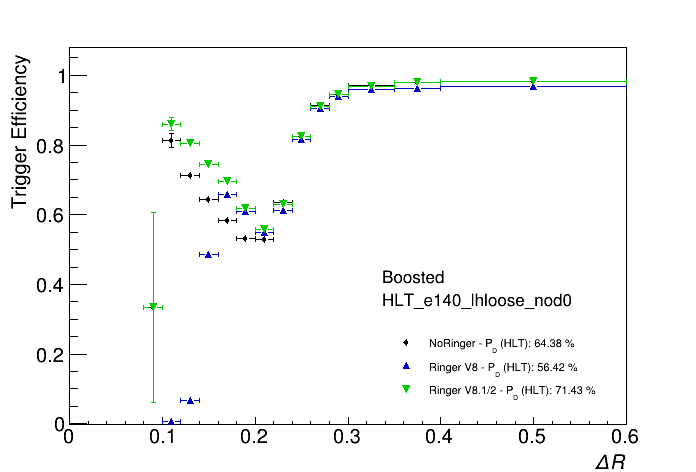

In [13]:
for step in ['L2Calo', 'L2', 'EFCalo', 'HLT']:
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/deltar'

    for chain in chain_list:
        
        trigger = step+'_'+chain

        m_info = np.array([make_dr_plot(boosted_table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '\Delta R', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text(0.55, 0.4, 'Boosted', textsize=0.04)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_boosted_deltaR_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_deltaR_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_deltaR_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

### Efficiency with respect to $pT$

In [27]:
def make_pt_plot(dataframe, chain, fake=False):
    var = 'trig_L2_el_pt'
    from Gaugi.constants import GeV, MeV
    # plot in eta need sum 1 in chain threshold 

    #m_bins = [4,7,10,15,20,25,30,35,40,45,50,60,80,150,300] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    m_bins = np.arange(0, 2000*10**3, step=50*10**3).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('pt_b_num', passed[var]/MeV, m_bins )
    #                                               /GeV
    h_den = hist1d('pt_b_den', total[var]/MeV, m_bins )
    #                                              /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

In [ ]:
for step in ['L2Calo', 'L2', 'EFCalo', 'HLT']:
#step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt'

    for chain in chain_list:
        
        trigger = step+'_'+chain

        m_info = np.array([make_pt_plot(boosted_table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], 'pT [MeV]', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text(0.55, 0.4, 'Boosted', textsize=0.04)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=0, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_boosted_pt_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_pt_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_pt_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_boosted_pt_L2Calo_e24_lhtight_root
Saving /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/pt/eff_boosted_pt_L2Calo_e26_lhtight_root


### Efficiency with respect to $< \mu >$

In [ ]:
def make_mu_plot(dataframe, chain, fake=False):
    var = 'avgmu'
    from Gaugi.constants import GeV, MeV
    # plot in eta need sum 1 in chain threshold 

    #m_bins = [4,7,10,15,20,25,30,35,40,45,50,60,80,150,300] # et_bins
    #m_bins = [15, 20, 30, 40, 50, 1000000]
    #m_bins = [10, 20, 30, 40, 50, 60, 70]
    m_bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                      *GeV
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) & (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
        #                                                                                                                       *GeV
    
    #step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    step_decision = chain
    #'L2Calo_e26_lhtight_nod0_ringer_v8_34_ivarloose'
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df[step_decision] == 1)]
    
    h_num = hist1d('mu_b_num', passed[var]/MeV, m_bins )
    #                                               /GeV
    h_den = hist1d('mu_b_den', total[var]/MeV, m_bins )
    #                                              /GeV
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

In [ ]:
for step in ['L2Calo', 'L2', 'EFCalo', 'HLT']:
#step = 'L2'
    plot_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler/kepler_imgs/effs/mu'

    for chain in chain_list:
        
        trigger = step+'_'+chain

        m_info = np.array([make_mu_plot(boosted_table, trigger.format(RINGER=alg)) for alg in ringer_list])

        # make the plot
        fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
        fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers)
        #rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
        rpl.format_canvas_axes(YTitleOffset = 0.95)
        labels = []
        for idx, ilabel in enumerate(label_list):
            labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
        add_legend( 0.55,0.15, labels)
        rpl.add_text(0.55, 0.4, 'Boosted', textsize=0.04)
        rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain.split('_')[0], chain.split('_')[1]), textsize=0.04)
        rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=0, ymaxf=1.1) 
        fig.show()
        print('Saving '+ plot_path+'/eff_boosted_mu_%s_%s_%s_root' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_mu_%s_%s_%s_root.pdf' %(step, chain.split('_')[0], chain.split('_')[1]))
        fig.savefig(plot_path+'/eff_boosted_mu_%s_%s_%s_root.png' %(step, chain.split('_')[0], chain.split('_')[1]))

In [ ]:
print('End of script')